In [1]:
import librosa
import numpy as np

def time_filtered():
    """
    - equal loudness curves model
    - STFT
    - filterbank with melscale bands in time domain
    """
    pass


In [2]:
filters = librosa.filters.mel(16000, 512, n_mels=48)
filters = [np.fft.irfft(filter ** 0.5) for filter in filters]

In [3]:
import matplotlib.pyplot as plt

plt.plot(filters[1])

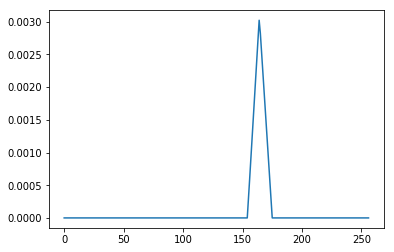

In [4]:
plt.plot(librosa.filters.mel(16000, 512, n_mels=48)[41])

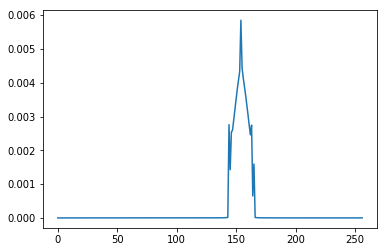

In [5]:
plt.plot(np.abs(np.fft.rfft(filters[40] * np.hamming(512))))

In [6]:
import scipy.io.wavfile as sio

In [7]:
signal = sio.read("datasets/clarin_mobile/raw/SES0100_ses/sent001_bndl/sent001.wav")[1]

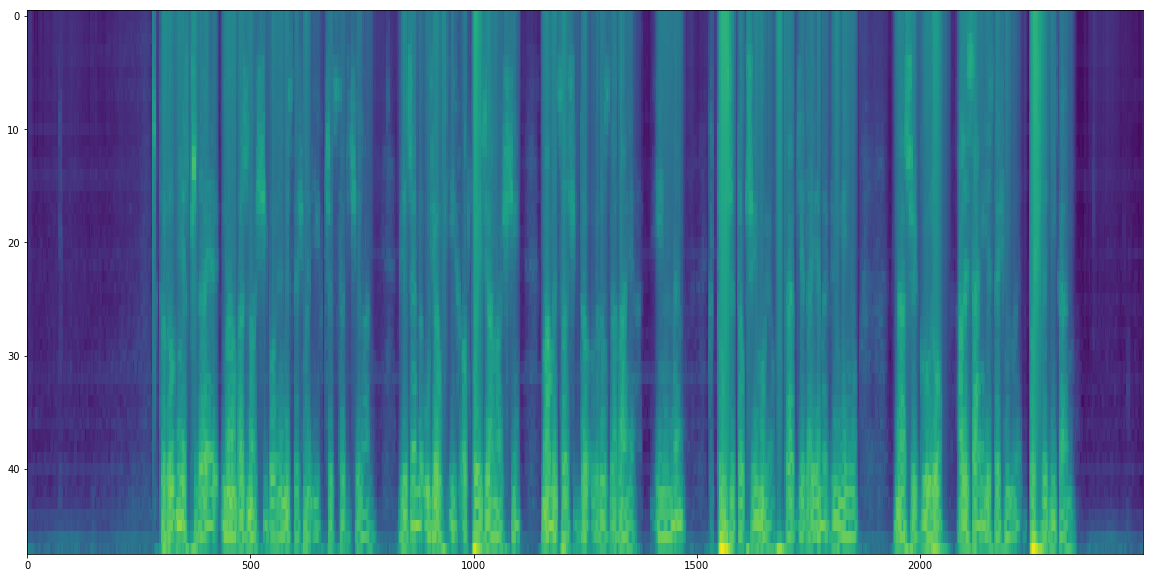

In [8]:
def framing(sig):
    frames = (len(sig) - 512 + 128) // 128
    return np.array([np.abs(sig[128 * x : 128 * x + 512]).max() for x in range(frames)])

bands = (np.convolve(signal, filter, mode='same') for filter in filters)
bands = np.array([framing(x) for x in bands])
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(np.log(bands ** 2), axis=0), aspect='auto')

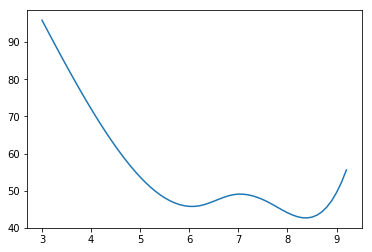

In [9]:
from scipy.interpolate import interp1d
f2 = interp1d(np.log([20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]), [96, 74, 60, 50, 46, 49, 47, 43, 56], kind='cubic')
args = 0.1 * np.arange(30, 10 * np.log(10000))
resp = f2(args)
plt.plot(args, resp)

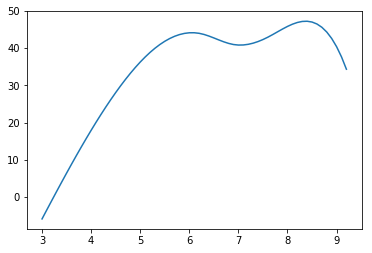

In [10]:
plt.plot(args, 90 - resp)

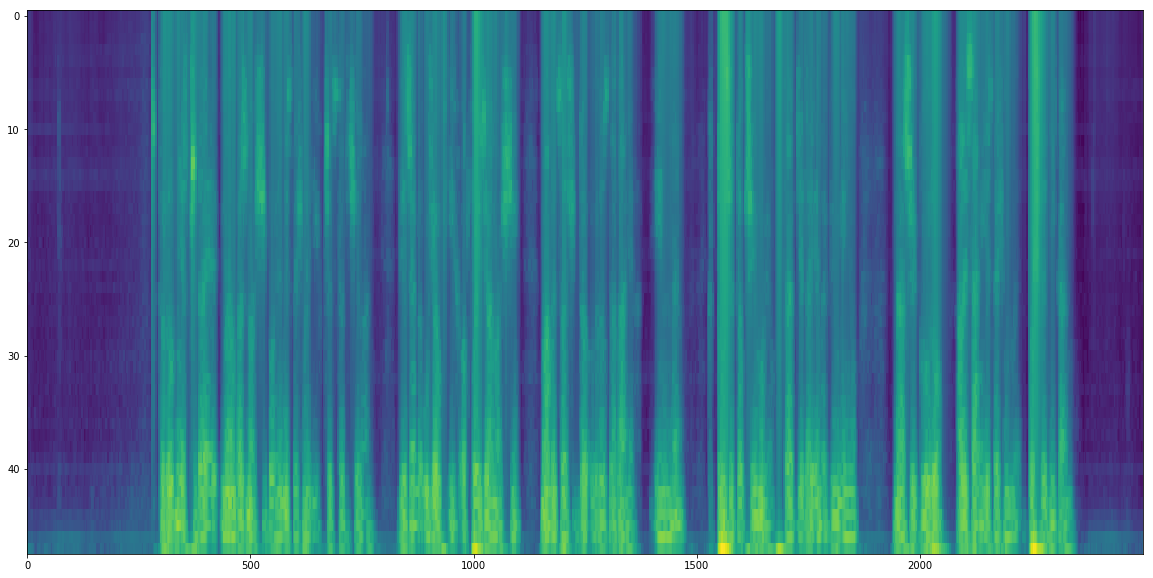

In [11]:
freqs = np.log(16000 / 512 * np.arange(1, 257))
freqs = np.concatenate([[0], f2(freqs).max() - f2(freqs)])
freqs = np.exp(2 * freqs / 10)
freqs = np.fft.irfft(freqs)
# freqws = filter that scales the sound appropriately

def framing(sig):
    frames = (len(sig) - 512 + 128) // 128
    return np.array([np.abs(sig[128 * x : 128 * x + 512]).max() for x in range(frames)])

bands = (np.convolve(np.convolve(signal, freqs, mode='same'), filter, mode='same') for filter in filters)
bands = np.array([framing(x) for x in bands])
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(np.log(bands ** 2), axis=0), aspect='auto')

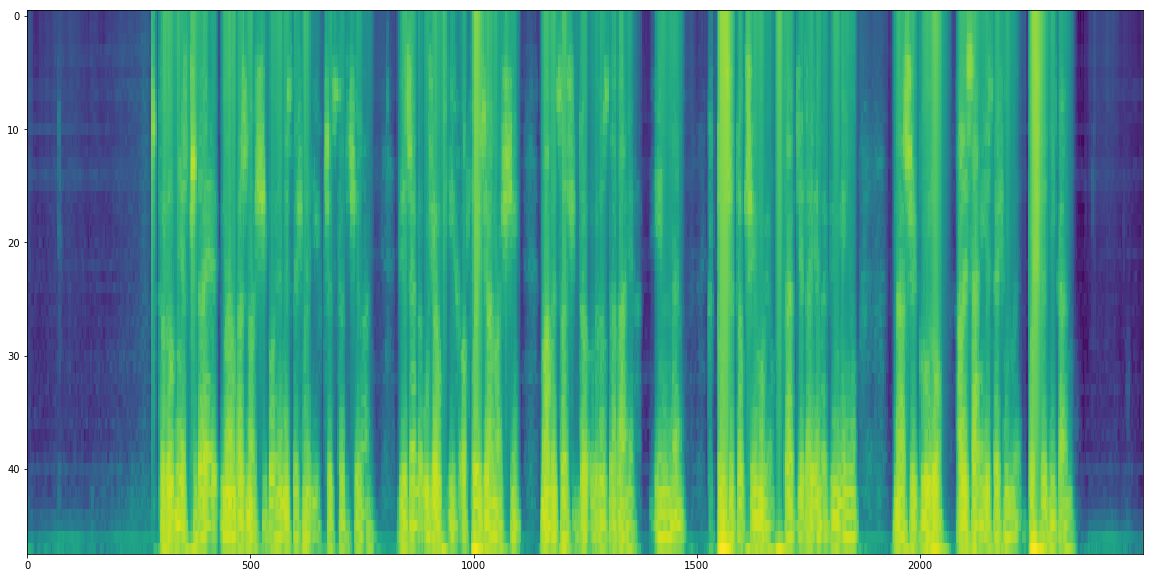

In [12]:
img = np.log(bands ** 2)
img = 3 * (img - img.min()) / (img.max() - img.min())
sigmoid = lambda x: 1 / (1 + np.exp(-x))
img = sigmoid(img)
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(img, axis=0), aspect='auto')

In [13]:
(img / img.std()).std()

1.0000000000000002

In [14]:
(bands / bands.std()).std()

1.0000000000000002

In [15]:
import scipy.stats as SS
SS.kurtosis((img / img.std()).reshape(-1))

-0.8243018266720941

In [16]:
import scipy.stats as SS
SS.kurtosis((bands / bands.std()).reshape(-1))

227.52409173682148

In [ ]:
# add effect of harmonics... - let the n

In [18]:
# chirp over the image
image = img[:]

0.7085062884019695 -0.4621273888332167


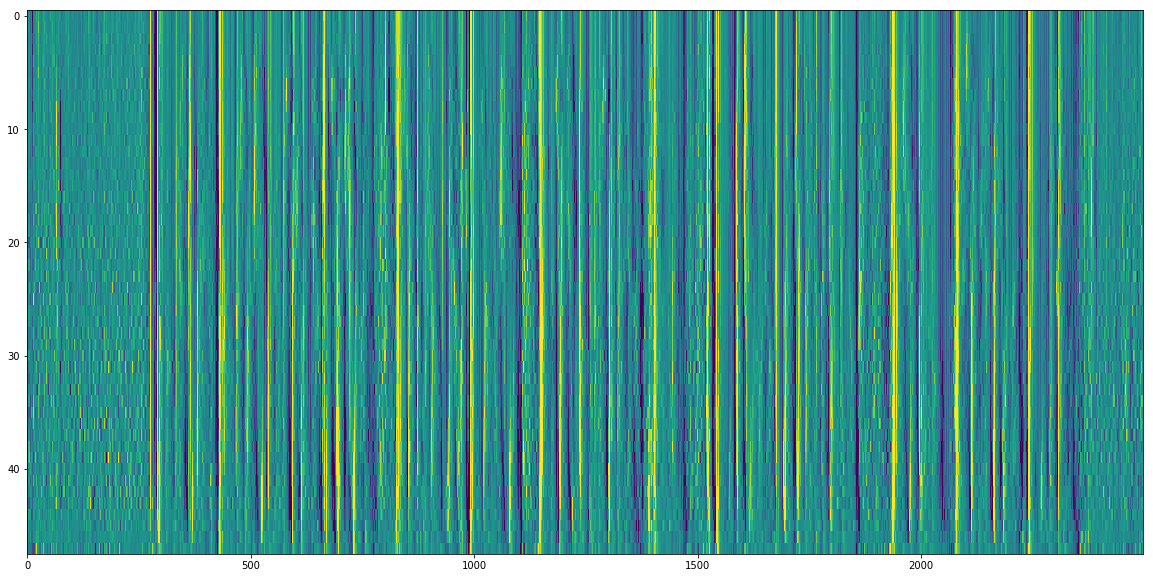

In [29]:
diff = 2 * image[:, 3:] + image[:, 2:-1] - image[:, 1:-2] - 2* image[:, :-3]
print(diff.max(), diff.min())
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(diff, axis=0), aspect='auto', vmin=-0.15, vmax=0.15)

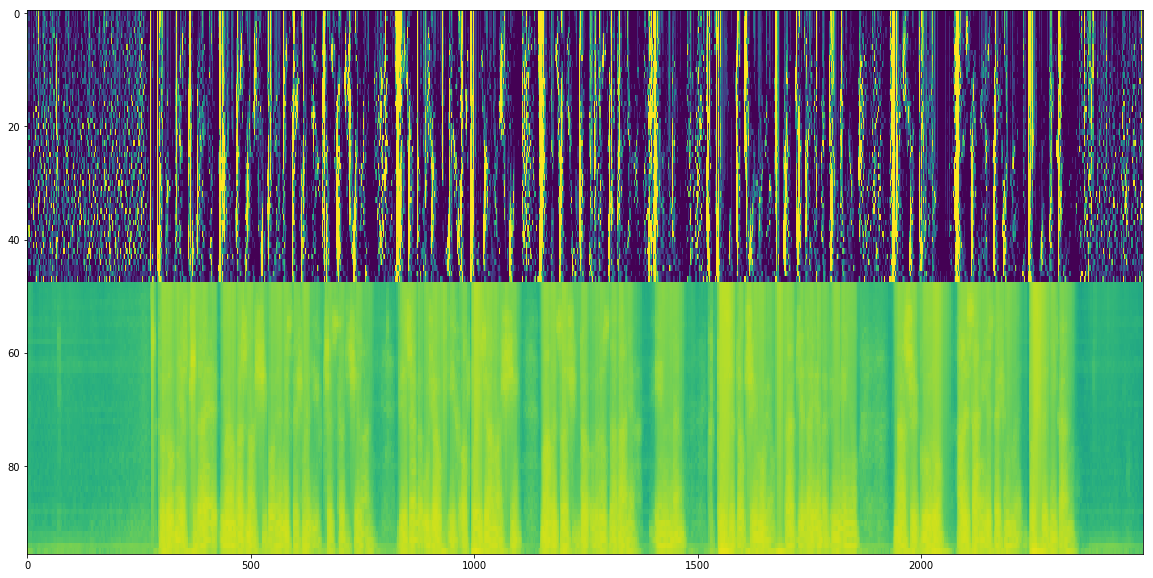

In [35]:
normix = np.vstack([img[:, 1:-2], (diff - diff.mean()) / diff.std()])
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(normix, axis=0), aspect='auto', vmin=-0.15, vmax=1)

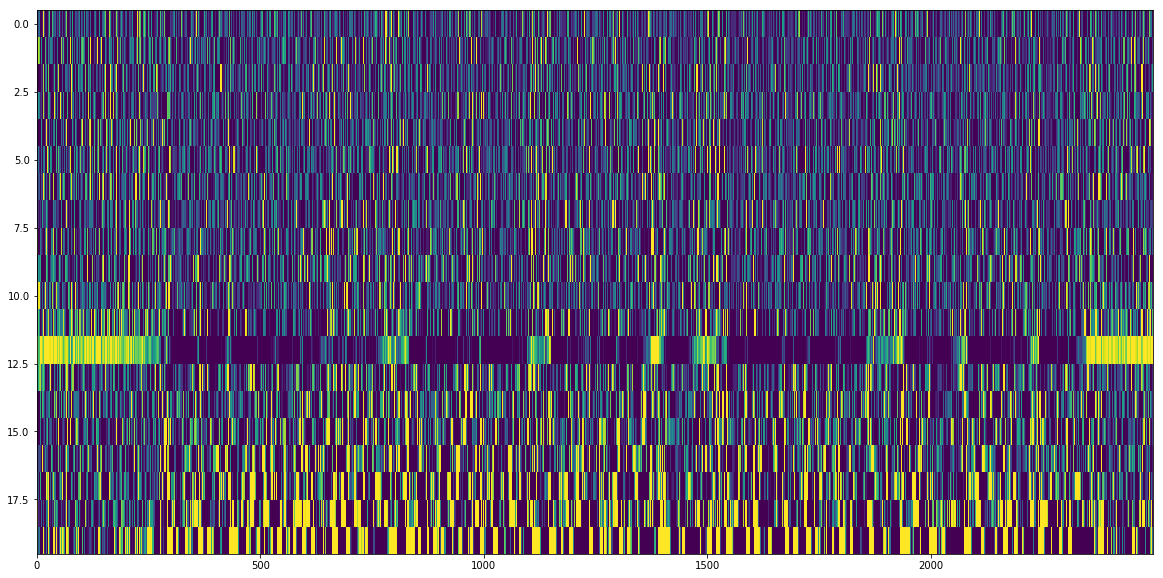

In [40]:
import sklearn.decomposition as skd
pca = skd.PCA(20)
pca.fit(normix.T)
short = pca.transform(normix.T).T
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(short, axis=0), aspect='auto', vmin=-0.15, vmax=1)

In [46]:
shortnorm = (short - short.min(1).reshape(-1,1)) / (short.max(1) - short.min(1)).reshape(-1,1)
shortnorm.std(1), shortnorm.mean(1)

(array([0.07269027, 0.07466648, 0.09000553, 0.08886184, 0.07958163,
        0.09507579, 0.08941122, 0.20998556, 0.12066868, 0.1110057 ,
        0.12405282, 0.10389172, 0.08999617, 0.11584397, 0.10729669,
        0.09857322, 0.11474458, 0.11632029, 0.12773198, 0.12103682]),
 array([0.25218131, 0.48364685, 0.41274994, 0.42295503, 0.4917966 ,
        0.4534963 , 0.40503458, 0.38667974, 0.49387372, 0.48010304,
        0.45730277, 0.45997744, 0.4816908 , 0.46941434, 0.48687746,
        0.48243919, 0.45934095, 0.49259363, 0.46581805, 0.50184775]))

In [ ]:
import scipy.signal as ss
import scipy as sp

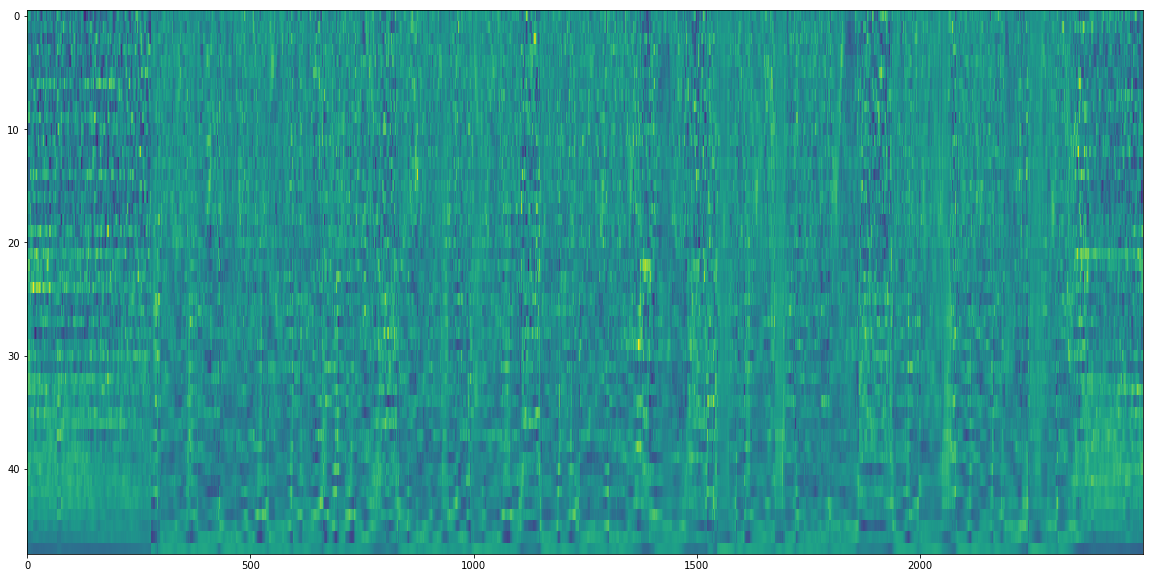

In [62]:
# You can see that upper bins have very high variability and my be treated as noise - lower bins have more predictive power

coeff = sp.fftpack.dct(img, axis=0)
coeff -= coeff.mean(1).reshape(-1, 1)
coeff /= coeff.std(1).reshape(-1, 1)
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(coeff, axis=0), aspect='auto')

[(array([  7.,  28.,  48., 104., 137.,  88.,  78.,  80.,  51.,  49.,  55.,
          50.,  30.,  40.,  58.,  80., 114., 131., 253., 298., 288., 223.,
         135.,  34.,  40.]),
  array([-2.30781169, -2.15582786, -2.00384403, -1.8518602 , -1.69987636,
         -1.54789253, -1.3959087 , -1.24392487, -1.09194103, -0.9399572 ,
         -0.78797337, -0.63598954, -0.4840057 , -0.33202187, -0.18003804,
         -0.02805421,  0.12392963,  0.27591346,  0.42789729,  0.57988112,
          0.73186495,  0.88384879,  1.03583262,  1.18781645,  1.33980028,
          1.49178412]),
  <a list of 25 Patch objects>),
 (array([ 27.,  11.,  15.,  16.,  14.,  17.,  13.,  26.,  38.,  56.,  46.,
          55.,  57., 127., 175., 191., 209., 216., 215., 246., 272., 244.,
         105.,  70.,  38.]),
  array([-3.548067  , -3.33812892, -3.12819085, -2.91825278, -2.7083147 ,
         -2.49837663, -2.28843856, -2.07850049, -1.86856241, -1.65862434,
         -1.44868627, -1.23874819, -1.02881012, -0.81887205, -0.608

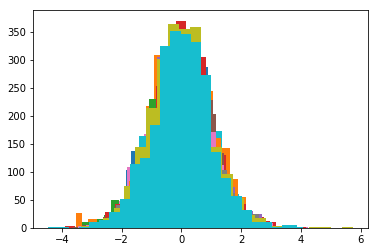

In [67]:
[plt.hist(band, bins=25) for band in coeff[:20]]

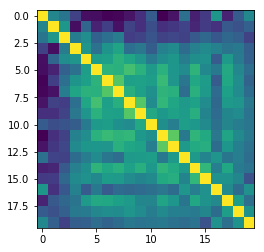

In [70]:
plt.imshow(np.cov(coeff[:20]))

In [71]:
# but this has nothing common with the presumed working of the ear - there is log scale and loudness scaling...
# there is no harmonics-relation and no edge detection

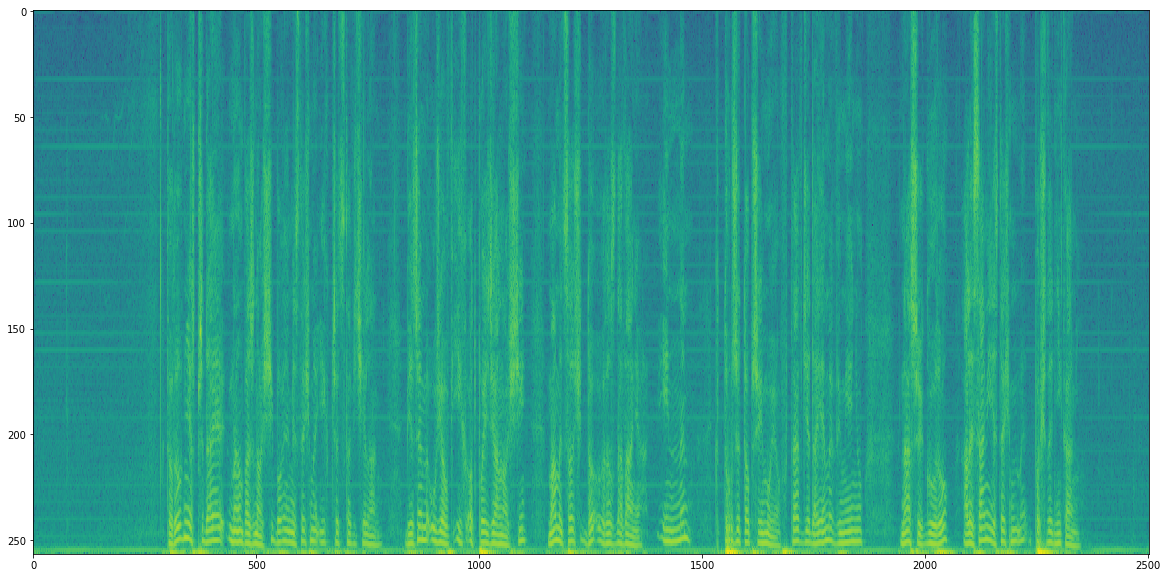

In [81]:
import librosa
img = np.log(np.abs(librosa.stft(signal.astype(np.float32), n_fft=512))**2)
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(img, axis=0), aspect='auto')

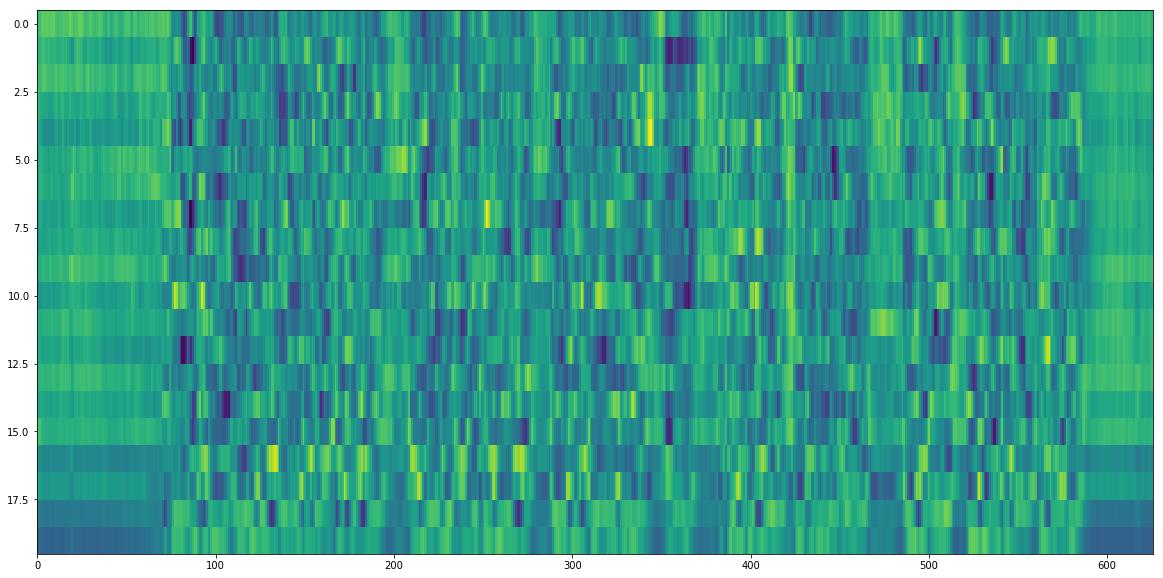

In [86]:
img = librosa.feature.mfcc(signal.astype(np.float32), n_mels=48)
img -= img.mean(1).reshape(-1, 1)
img /= img.std(1).reshape(-1, 1)
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(img, axis=0), aspect='auto')

Text(0.5,1,'Time filter-based MFCC something something features')

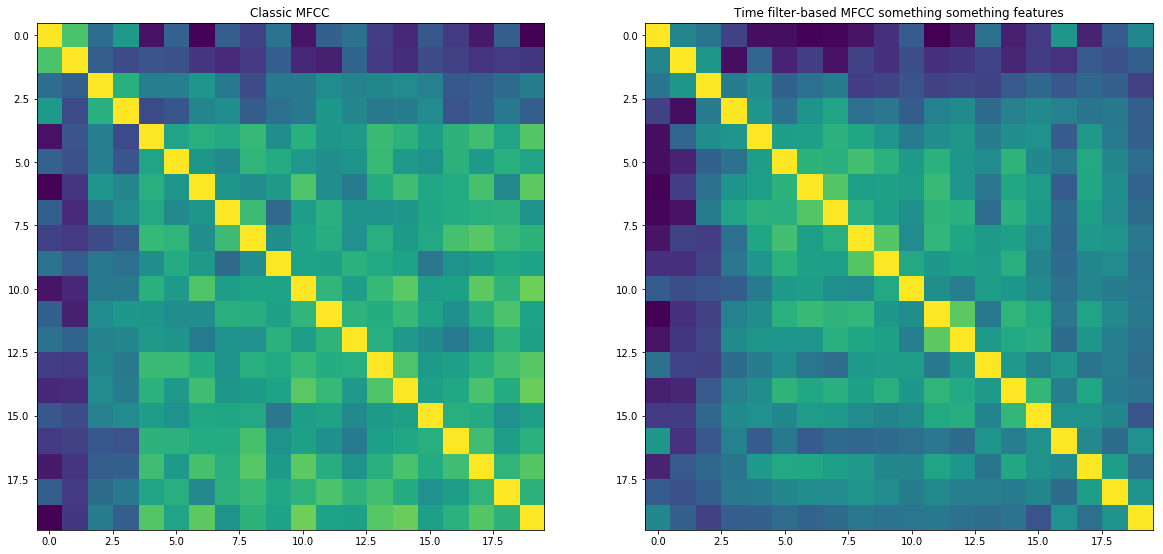

In [99]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(np.cov(img[:20]))
ax[0].set_title("Classic MFCC")
ax[1].imshow(np.cov(coeff[:20]))
ax[1].set_title("Time filter-based MFCC something something features")

-0.8776979487474058 0.6478462071206792 -0.7251634694312704 1.0016000000000005


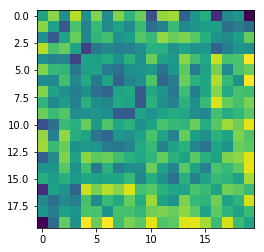

In [94]:
diff = np.cov(img[:20])- np.cov(coeff[:20])
print(diff.min(), diff.max(), np.cov(img[:20]).min(), np.cov(img[:20]).max())
plt.imshow(diff)

In [105]:
# Shapiro-Wilk
import scipy.stats as sst
SWtest_mfcc = [sst.shapiro(img[x]) for x in range(20)]
SWtest_my_feats = [sst.shapiro(coeff[x]) for x in range(20)]

In [146]:
np.mean([x[1] for x in SWtest_mfcc]), np.mean([x[1] for x in SWtest_my_feats])

(0.0017303012790135307, 0.0010243701526848514)

In [147]:
np.max([x[1] for x in SWtest_mfcc]), np.max([x[1] for x in SWtest_my_feats])

(0.029851071536540985, 0.007674954365938902)

In [148]:
np.min([x[1] for x in SWtest_mfcc]), np.min([x[1] for x in SWtest_my_feats])

(3.0818332932848176e-16, 7.993146570355189e-41)

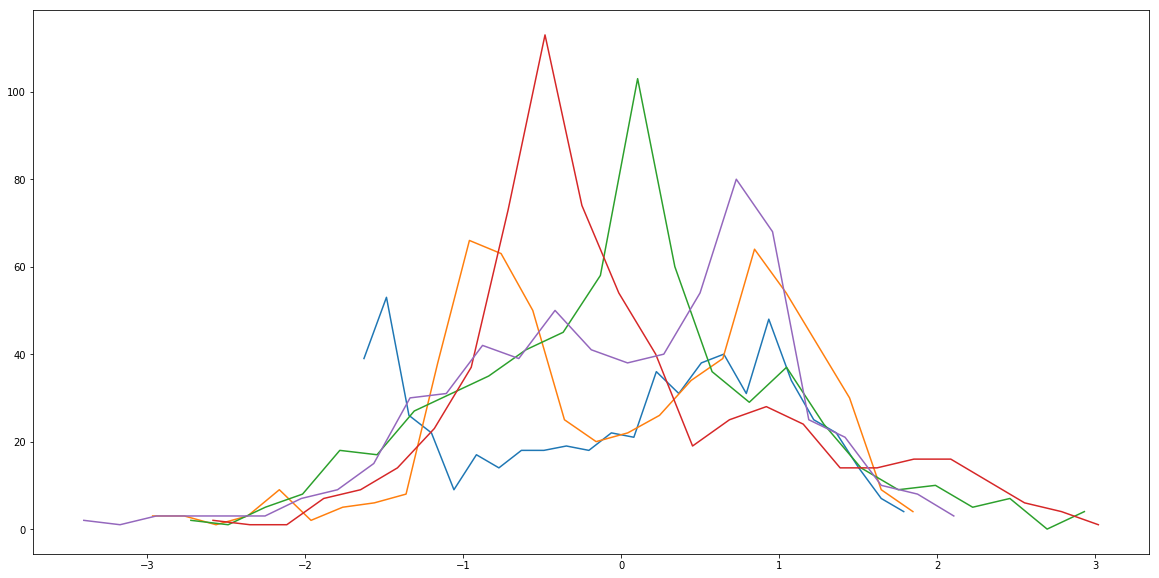

In [150]:
plt.figure(figsize=(20, 10))
for f_bin in range(5):
    y, x = np.histogram(img[f_bin], bins=25)
    x = (x[1:] + x[:-1]) / 2
    plt.plot(x,y)

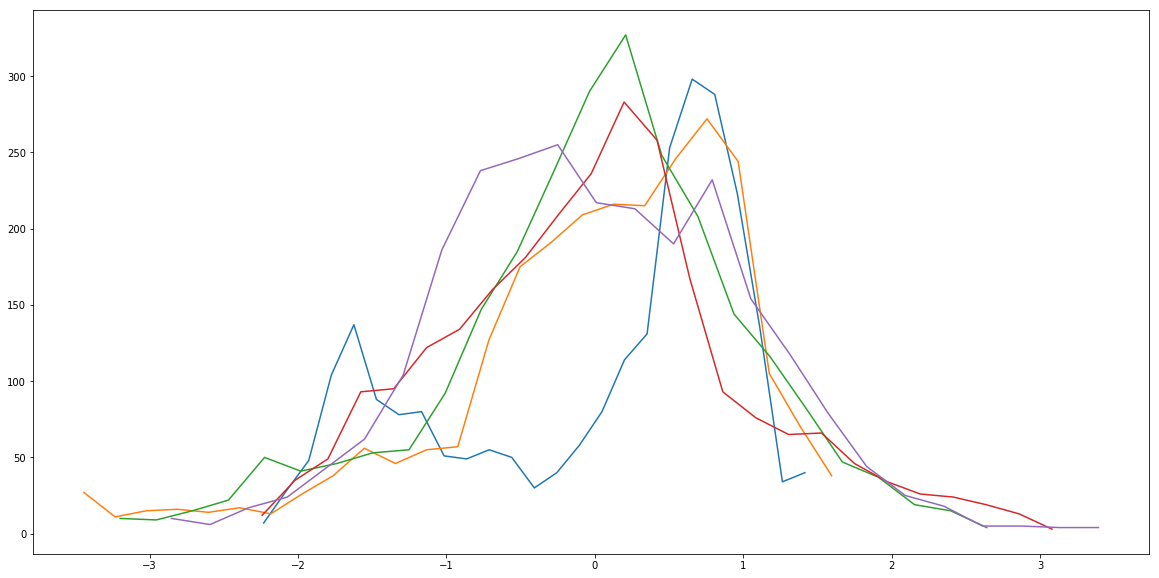

In [149]:
plt.figure(figsize=(20, 10))
for f_bin in range(5):
    y, x = np.histogram(coeff[f_bin], bins=25)
    x = (x[1:] + x[:-1]) / 2
    plt.plot(x,y)

Text(0.5,1,'Time filter-based MFCC something something features')

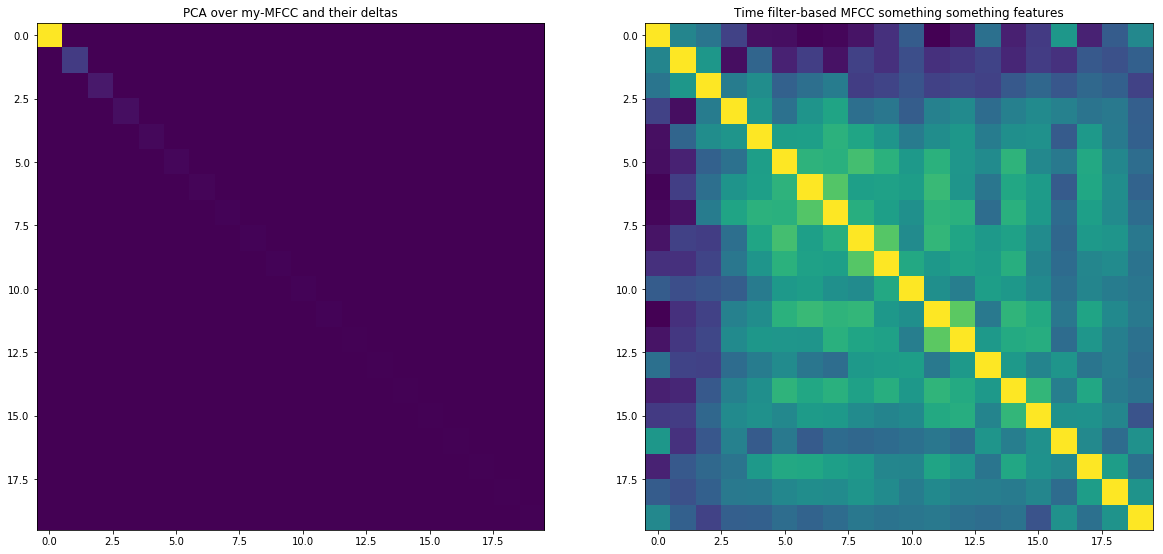

In [159]:
mymfcc 

fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(np.cov(short[:]))
ax[0].set_title("PCA over my-MFCC and their deltas")
ax[1].imshow(np.cov(coeff[:20]))
ax[1].set_title("Time filter-based MFCC something something features")

# Modelling harmonic series

Question: whether harmonics of speech should be in phase?

Human ear detects the peaks in time and how it synchronizes with some internal clock

Waves:
428
300
550
0
Waves:
57
150
50
50
Waves:
60
210
70
40
Waves:
127
300
150
100


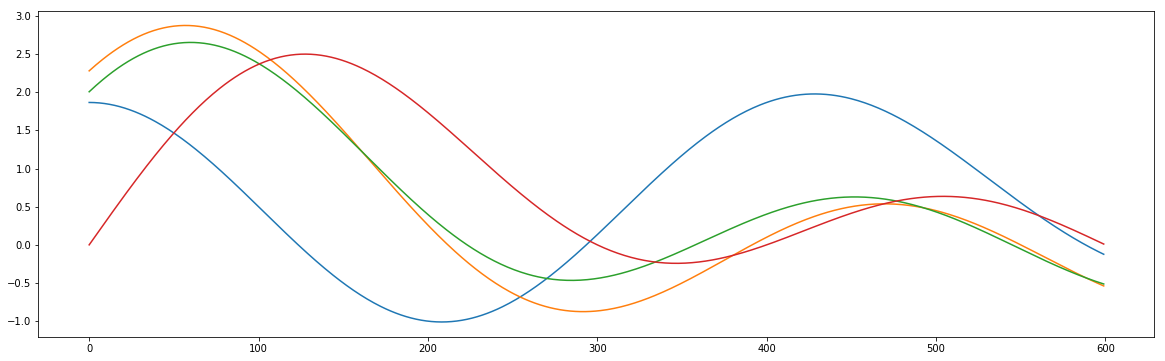

In [184]:
import numpy as np
plt.figure(figsize=(20,6))
a, b, c = 0, 200, 100
plt.plot(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200))
print("Waves:")
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200)))
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600)))
print(np.argmax(np.sin((np.arange(600) + b) * np.pi / 300)))
print(np.argmax(np.sin((np.arange(600) + c) * np.pi / 200)))
a, b, c = 150, 100, 50
plt.plot(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200))
print("Waves:")
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200)))
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600)))
print(np.argmax(np.sin((np.arange(600) + b) * np.pi / 300)))
print(np.argmax(np.sin((np.arange(600) + c) * np.pi / 200)))
a, b, c = 90, 80, 60
plt.plot(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200))
print("Waves:")
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200)))
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600)))
print(np.argmax(np.sin((np.arange(600) + b) * np.pi / 300)))
print(np.argmax(np.sin((np.arange(600) + c) * np.pi / 200)))
a, b, c = 0, 0, 0
plt.plot(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200))
print("Waves:")
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600) + np.sin((np.arange(600) + b) * np.pi / 300) + np.sin((np.arange(600) + c) * np.pi / 200)))
print(np.argmax(np.sin((np.arange(600) + a) * np.pi / 600)))
print(np.argmax(np.sin((np.arange(600) + b) * np.pi / 300)))
print(np.argmax(np.sin((np.arange(600) + c) * np.pi / 200)))


In [186]:
# Synchrony of phases or dominant phase cannot show where peak is, so probably 
# Filter for harmonics should take account how concordant are the peak

"""
So for N = 1, 2, 3...
response(x) = f(x) + 1/2 f(x/2) + 1/3 * f(x/3) ...
"""

'\nSo for N = 1, 2, 3...\nresponse(x) = f(x) + 1/2 f(x/2) + 1/3 * f(x/3) ...\n'

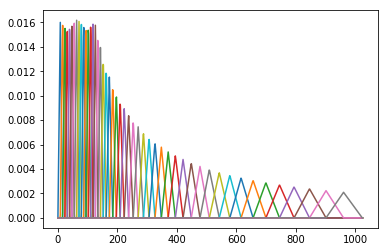

In [193]:
# In frequency domain in high resolution:

hrfilt = librosa.filters.mel(16000, 2048, n_mels=48)
_ = plt.plot(hrfilt.T)

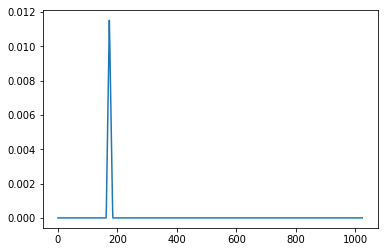

In [196]:
plt.plot(hrfilt[20, :])


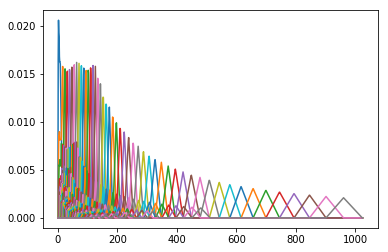

In [221]:
data = hrfilt.copy()
for ix, filter in enumerate(hrfilt):
    a = filter.copy()
    b = a.copy()
    b[:513] += 0.5 * a[::2]
    b[:342] += 0.3333 * a[::3]
    b[:257] += 0.25 * a[::4]
    b[:205] += 0.20 * a[::5]
    b[:171] += 0.167 * a[::6]
    b[:147] += 0.1429 * a[::7]
    b[:129] += 0.125 * a[::8]
    plt.plot(b)
    data[ix, :] = b
timefilts = np.zeros([data.shape[0], 512])
for ix, time in enumerate(data):
    timefilts[ix, :] = np.fft.irfft(time)[::4]


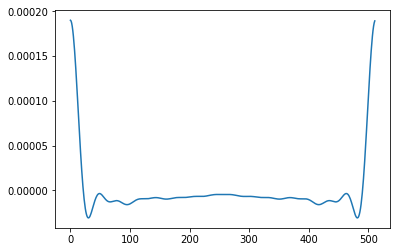

In [222]:
plt.plot(timefilts[0, :])

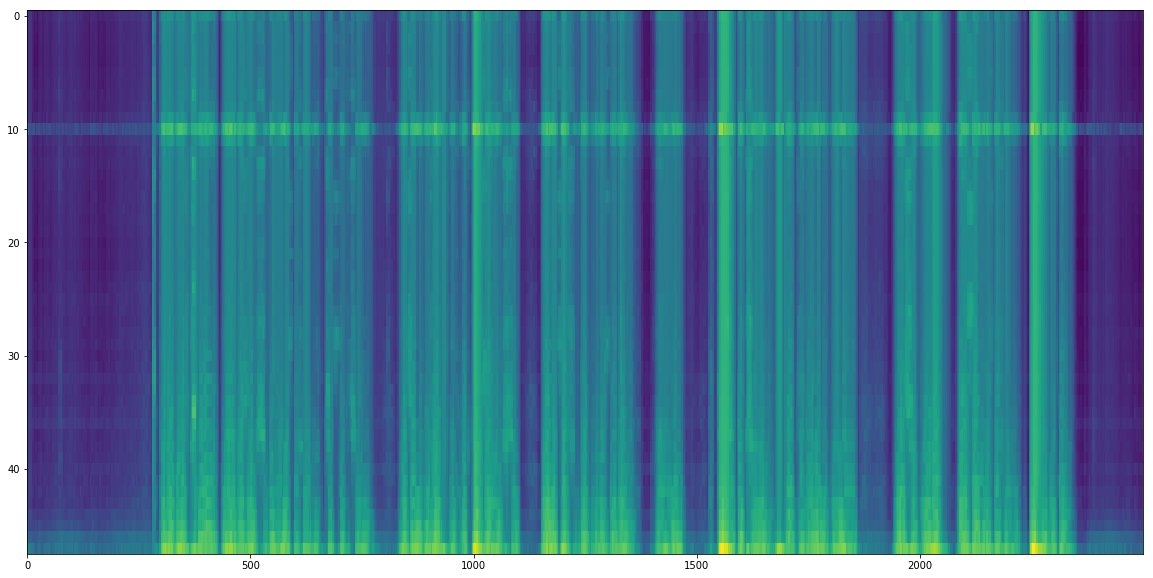

In [223]:
def framing(sig):
    frames = (len(sig) - 512 + 128) // 128
    return np.array([np.abs(sig[128 * x : 128 * x + 512]).max() for x in range(frames)])

bands = (np.convolve(signal, filter, mode='same') for filter in timefilts)
bands = np.array([framing(x) for x in bands])
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(np.log(bands ** 2), axis=0), aspect='auto')

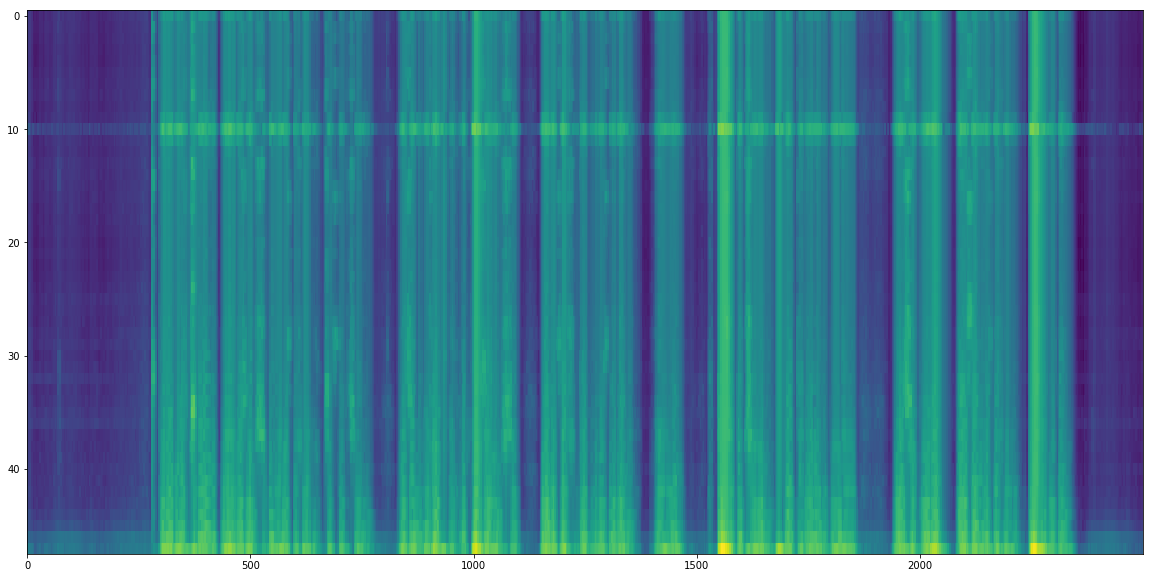

In [225]:
freqs = np.log(16000 / 512 * np.arange(1, 257))
freqs = np.concatenate([[0], f2(freqs).max() - f2(freqs)])
freqs = np.exp(2 * freqs / 10)
freqs = np.fft.irfft(freqs)
# freqws = filter that scales the sound appropriately

def framing(sig):
    frames = (len(sig) - 512 + 128) // 128
    return np.array([np.abs(sig[128 * x : 128 * x + 512]).max() for x in range(frames)])

bands = (np.convolve(np.convolve(signal, freqs, mode='same'), filter, mode='same') for filter in timefilts)
bands = np.array([framing(x) for x in bands])
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(np.log(bands ** 2), axis=0), aspect='auto')

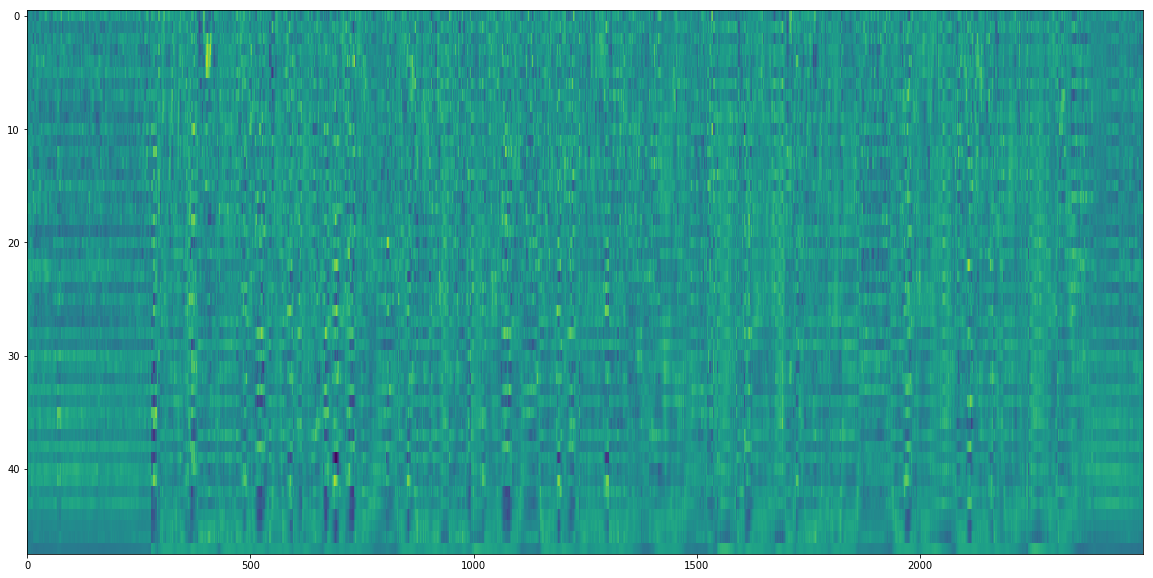

In [226]:
coeff = sp.fftpack.dct(np.log(bands ** 2), axis=0)
coeff -= coeff.mean(1).reshape(-1, 1)
coeff /= coeff.std(1).reshape(-1, 1)
plt.figure(figsize=(20, 10))
plt.imshow(np.flip(coeff, axis=0), aspect='auto')

Text(0.5,1,'Improved, harmonicized MFCC something something features')

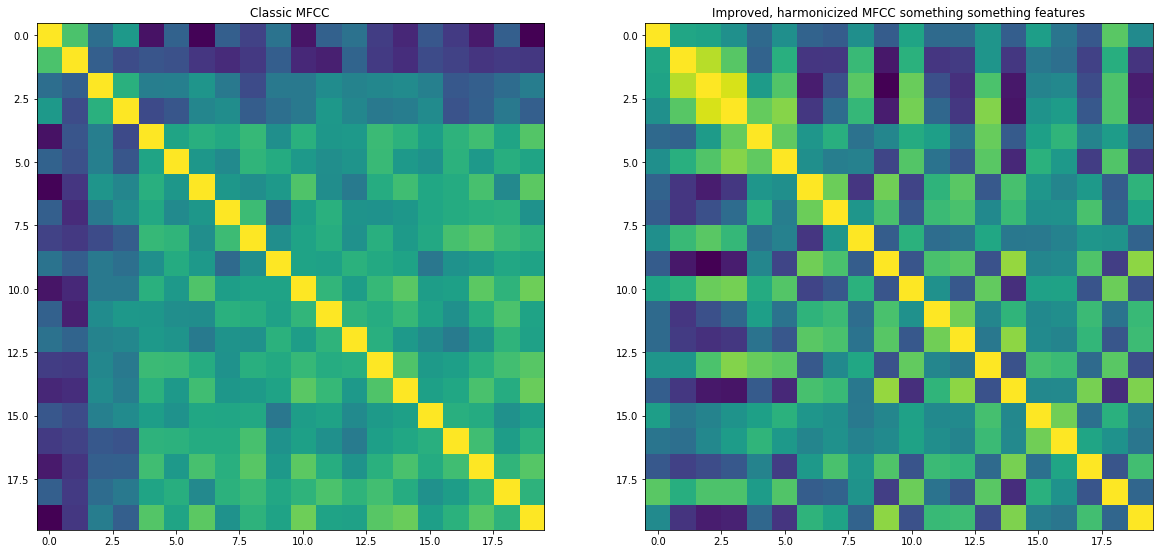

In [227]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(np.cov(img[:20]))
ax[0].set_title("Classic MFCC")
ax[1].imshow(np.cov(coeff[:20]))
ax[1].set_title("Improved, harmonicized MFCC something something features")

In [228]:
# Shapiro-Wilk for the other MFCC features
import scipy.stats as sst
[sst.shapiro(coeff[x]) for x in range(20)]

[(0.9071099758148193, 1.4372325101544964e-36),
 (0.9893466830253601, 1.0878321897792032e-12),
 (0.9427673816680908, 4.461601786003625e-30),
 (0.8810316920280457, 3.834415026885927e-40),
 (0.940463662147522, 1.397538556884705e-30),
 (0.9152042269706726, 2.6946577912544137e-35),
 (0.9253923892974854, 1.5065074988710972e-33),
 (0.9970636367797852, 0.00010032067802967504),
 (0.7965386509895325, 0.0),
 (0.9750186800956726, 1.6597958986657568e-20),
 (0.9540470242500305, 2.360318628518916e-27),
 (0.9973234534263611, 0.00025005885981954634),
 (0.9871091246604919, 2.920674295405108e-14),
 (0.9209060668945312, 2.435350165947748e-34),
 (0.978457510471344, 5.312235577901033e-19),
 (0.9928750395774841, 1.0413511164486522e-09),
 (0.9726062417030334, 1.785851438552876e-21),
 (0.9951980710029602, 3.188720825164637e-07),
 (0.9805710315704346, 5.4722191326088425e-18),
 (0.963325023651123, 1.0691032487627105e-24)]

Text(0.5,1,'Improved, harmonicized MFCC something something features')

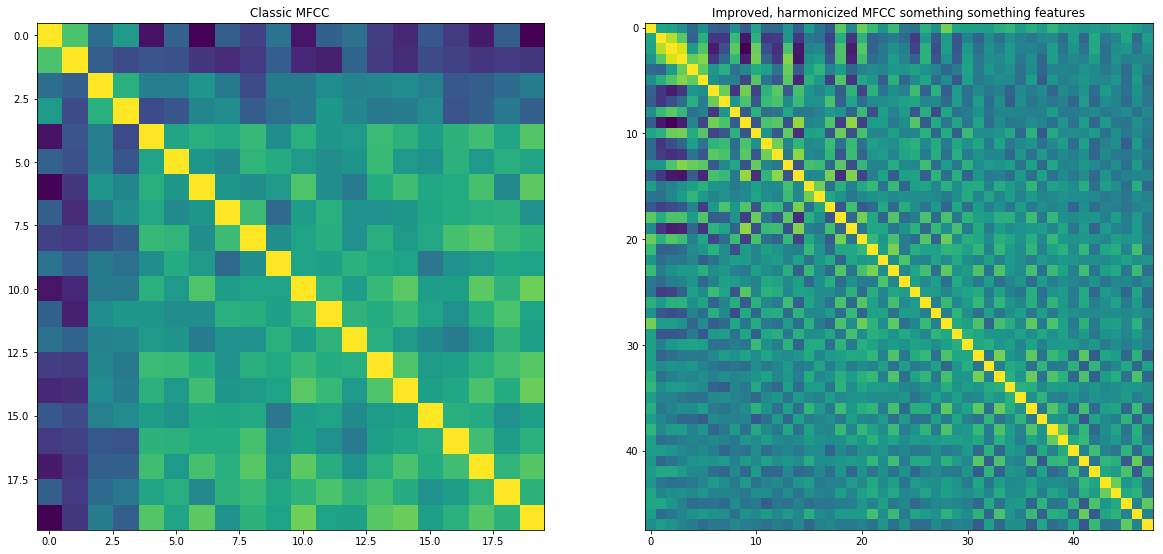

In [230]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(np.cov(img[:48]))
ax[0].set_title("Classic MFCC")
ax[1].imshow(np.cov(coeff[:48]))
ax[1].set_title("Improved, harmonicized MFCC something something features")

Text(0.5,1,'Spec')

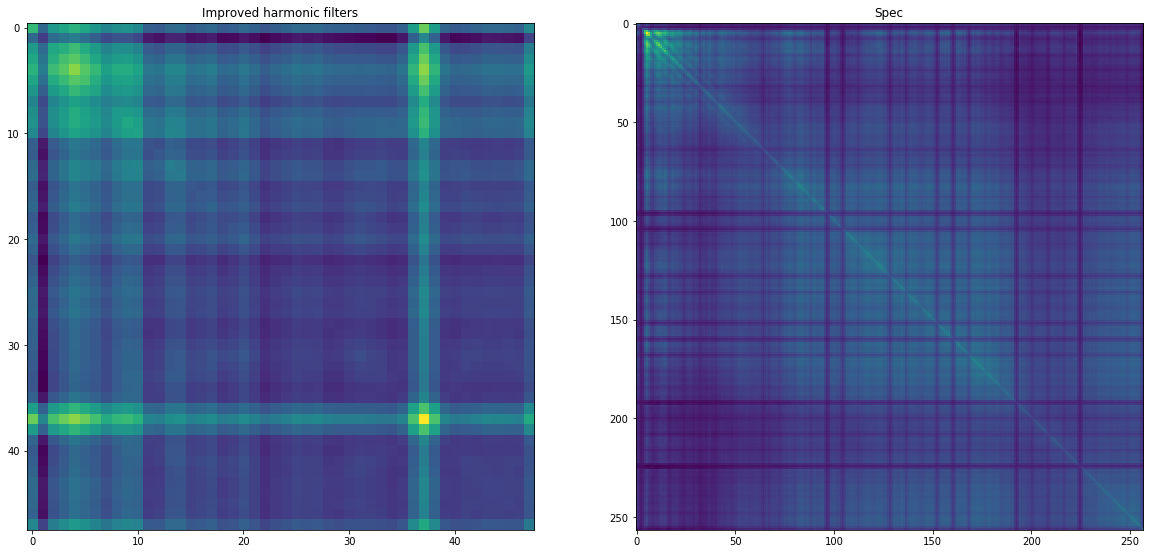

In [232]:
fig = plt.figure(figsize=(20, 10))
ax = fig.subplots(1, 2)
ax[0].imshow(np.cov(np.log(bands ** 2)))
ax[0].set_title("Improved harmonic filters")
ax[1].imshow(np.cov(np.log(np.abs(librosa.stft(signal.astype(np.float32), n_fft=512))**2)))
ax[1].set_title("Spec")

In [ ]:
# To be done: onset detection features...